# IOI Circuit Replication Validation

**End-to-End Validation Against "Interpretability in the Wild" (Wang et al. 2022)**

This notebook validates our implementation of the Indirect Object Identification (IOI) circuit discovery against the original paper's findings.

## Paper Reference
Wang, K., et al. (2022). Interpretability in the Wild: a Circuit for Indirect Object Identification in GPT-2 small. *ICLR 2023*.

## Implementation Reference
ARENA 1.4.1: Indirect Object Identification

---

## Setup

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import torch

# Add project root to path
sys.path.append('..')

# Import our modules
from src.data.dataset import generate_ioi_dataset, load_ioi_dataset
from src.model.model_loader import load_ioi_model
from src.analysis.ioi_baseline import run_baseline, compute_logit_diff
from src.analysis.activation_patching import (
    patch_all_layers,
    patch_all_heads,
    analyze_example_patching
)
from src.analysis.attention_analysis import (
    find_all_ioi_heads,
    analyze_duplicate_token_attention,
    analyze_s_inhibition_attention,
    analyze_name_mover_attention
)
from src.analysis.path_patching import analyze_ioi_circuit_paths
from src.analysis.circuit_discovery import (
    discover_ioi_circuit,
    validate_circuit,
    print_circuit_summary
)
from src.analysis.logit_attribution import (
    compare_io_vs_s_attribution,
    plot_logit_attribution,
    analyze_circuit_with_dla
)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

/home/alex/mech_interp/mech_interp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful
PyTorch version: 2.9.0+cu128
Device: CUDA


## Expected Results from Original Paper

### Key Findings to Validate:

1. **Baseline Performance**
   - Model accuracy on IOI task: ~95% (paper reports high accuracy)
   - Logit difference (IO - S): Positive and substantial (typically 5-10)

2. **Circuit Components** (from paper Fig 2 & 3)
   - **Duplicate Token Heads** (early layers 0-3): L0H1, L2H2, L3H0, etc.
   - **S-Inhibition Heads** (middle layers 7-8): L7H3, L7H9, L8H6, L8H10
   - **Name Mover Heads** (late layers 9-11): L9H6, L9H9, L10H0, L10H2, L11H10

3. **Activation Patching Effects**
   - Name mover heads: High positive effect (>0.5)
   - S-inhibition heads: Moderate positive effect (0.2-0.5)
   - Duplicate token heads: Low-moderate effect (0.1-0.3)

4. **Path Patching**
   - Strong paths: Duplicate → S-inhibition
   - Strong paths: S-inhibition → Name mover
   - Some direct paths: Duplicate → Name mover

5. **Direct Logit Attribution**
   - Circuit heads account for 80-95% of logit difference
   - Name movers: Large positive contribution to IO token
   - S-inhibition: Large negative contribution to S token

---
## Phase 1: Data Generation and Model Loading

In [2]:
print("="*80)
print("PHASE 1: DATA GENERATION AND MODEL LOADING")
print("="*80)

# Generate datasets
print("\n1. Generating ABBA dataset (clean prompts)...")
generate_ioi_dataset(n_examples=500, template="ABBA", seed=42)
abba_dataset = load_ioi_dataset("data/ioi_abba.json")
print(f"   Generated {len(abba_dataset)} ABBA examples")

print("\n2. Generating ABC dataset (corrupted prompts)...")
generate_ioi_dataset(n_examples=500, template="ABC", seed=42)
abc_dataset = load_ioi_dataset("data/ioi_abc.json")
print(f"   Generated {len(abc_dataset)} ABC examples")

# Load model
print("\n3. Loading GPT-2 Small with TransformerLens...")
device = "cuda" if torch.cuda.is_available() else "cpu"
result = load_ioi_model(device=device)
model = result["model"]
config = result["config"]

print(f"   Model: gpt2-small")
print(f"   Layers: {config['n_layers']}")
print(f"   Heads: {config['n_heads']}")
print(f"   Device: {config['device']}")

print("\n✓ Phase 1 complete")

PHASE 1: DATA GENERATION AND MODEL LOADING

1. Generating ABBA dataset (clean prompts)...


   Generated 500 ABBA examples

2. Generating ABC dataset (corrupted prompts)...


`torch_dtype` is deprecated! Use `dtype` instead!


   Generated 500 ABC examples

3. Loading GPT-2 Small with TransformerLens...
Loading GPT2-small on cuda...


Loaded pretrained model gpt2-small into HookedTransformer
Model loaded successfully!
  Layers: 12
  Heads: 12
  Model dim: 768
  Vocab size: 50257
   Model: gpt2-small
   Layers: 12
   Heads: 12
   Device: cuda

✓ Phase 1 complete


---
## Phase 2: Baseline Performance

In [3]:
print("="*80)
print("PHASE 2: BASELINE PERFORMANCE")
print("="*80)

# Run baseline on sample
print("\nRunning baseline analysis on 100 examples...")
baseline_results = run_baseline(
    model,
    "data/ioi_abba.json",
    max_examples=100
)

# Extract metrics
accuracy = baseline_results["accuracy"]
mean_logit_diff = baseline_results["mean_logit_diff"]
std_logit_diff = baseline_results["std_logit_diff"]

print("\n" + "="*60)
print("BASELINE RESULTS")
print("="*60)
print(f"Accuracy: {accuracy:.1%}")
print(f"Mean Logit Diff (IO - S): {mean_logit_diff:.3f} ± {std_logit_diff:.3f}")
print("="*60)

# Validation against paper
validation_report = []

print("\n📊 VALIDATION CHECK 1: Baseline Performance")
if accuracy >= 0.90:
    print(f"   ✓ PASS: Accuracy {accuracy:.1%} >= 90% (paper expects ~95%)")
    validation_report.append({"test": "Baseline Accuracy", "status": "PASS", "value": f"{accuracy:.1%}"})
else:
    print(f"   ✗ FAIL: Accuracy {accuracy:.1%} < 90%")
    validation_report.append({"test": "Baseline Accuracy", "status": "FAIL", "value": f"{accuracy:.1%}"})

if mean_logit_diff >= 3.0:
    print(f"   ✓ PASS: Mean logit diff {mean_logit_diff:.3f} >= 3.0")
    validation_report.append({"test": "Logit Difference", "status": "PASS", "value": f"{mean_logit_diff:.3f}"})
else:
    print(f"   ✗ FAIL: Mean logit diff {mean_logit_diff:.3f} < 3.0")
    validation_report.append({"test": "Logit Difference", "status": "FAIL", "value": f"{mean_logit_diff:.3f}"})

print("\n✓ Phase 2 complete")

PHASE 2: BASELINE PERFORMANCE

Running baseline analysis on 100 examples...
Loading dataset from data/ioi_abba.json...
Loaded 100 examples

Running baseline evaluation...


  Processing example 50/100...


  Processing example 100/100...

BASELINE RESULTS
Number of examples: 100
Accuracy: 87.00% (87/100)
Mean logit diff: 4.036
Median logit diff: 3.891
Std logit diff: 1.633

BASELINE RESULTS
Accuracy: 87.0%
Mean Logit Diff (IO - S): 4.036 ± 1.633

📊 VALIDATION CHECK 1: Baseline Performance
   ✗ FAIL: Accuracy 87.0% < 90%
   ✓ PASS: Mean logit diff 4.036 >= 3.0

✓ Phase 2 complete


---
## Phase 3: Activation Patching

In [ ]:
print("="*80)
print("PHASE 3: ACTIVATION PATCHING")
print("="*80)

# Use first example for detailed analysis
example = abba_dataset[0]
clean_prompt = example["prompt"]
print(f"\nClean prompt: {clean_prompt}")

# Use the dataset's corrupted prompt (which correctly swaps subject)
corrupted_prompt = example["corrupted_prompt"]
print(f"Corrupted prompt: {corrupted_prompt}")

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

io_token_id = model.to_single_token(" " + example["io_name"])
s_token_id = model.to_single_token(" " + example["s_name"])

# Patch all layers
print("\n1. Patching residual stream at all layers...")
layer_results = patch_all_layers(
    model, clean_tokens, corrupted_tokens,
    io_token_id, s_token_id
)
layer_effects = layer_results['layer_effects']

# Plot layer effects
plt.figure(figsize=(12, 5))
plt.plot(range(len(layer_effects)), layer_effects, marker='o')
plt.xlabel('Layer')
plt.ylabel('Patching Effect')
plt.title('Activation Patching by Layer\n(Effect of restoring clean activations)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='High Effect (>0.5)')
plt.legend()
plt.tight_layout()
plt.savefig('results/activation_patching_layers.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTop 3 most important layers:")
top_layers = sorted(enumerate(layer_effects), key=lambda x: x[1], reverse=True)[:3]
for layer, effect in top_layers:
    print(f"   Layer {layer}: {effect:.3f}")

# Patch all heads
print("\n2. Patching all attention heads...")
head_results = patch_all_heads(
    model, clean_tokens, corrupted_tokens,
    io_token_id, s_token_id
)
head_effects = head_results['head_effects']

# Reshape for heatmap
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    head_effects,
    cmap='RdYlGn',
    center=0,
    vmin=-0.2,
    vmax=1.0,
    cbar_kws={'label': 'Patching Effect'},
    xticklabels=range(n_heads),
    yticklabels=range(n_layers)
)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Activation Patching by Head\n(Higher = More Important for IOI Task)')
plt.tight_layout()
plt.savefig('results/activation_patching_heads.png', dpi=150, bbox_inches='tight')
plt.show()

# Find top heads
print(f"\nTop 10 most important heads:")
# Flatten the 2D array and get top heads
flat_effects = []
for layer in range(n_layers):
    for head in range(n_heads):
        flat_effects.append(((layer, head), head_effects[layer, head]))
top_heads = sorted(flat_effects, key=lambda x: x[1], reverse=True)[:10]
for (layer, head), effect in top_heads:
    print(f"   L{layer}H{head}: {effect:.3f}")

print("\n✓ Phase 3 complete")

---
## Phase 4: Attention Pattern Analysis

In [5]:
print("="*80)
print("PHASE 4: ATTENTION PATTERN ANALYSIS")
print("="*80)

# Find all IOI heads using attention patterns
print("\nFinding IOI circuit heads using attention patterns...")
print("(Using 50 examples for robustness)\n")

ioi_heads = find_all_ioi_heads(
    model,
    "data/ioi_abba.json",
    max_examples=50,
    duplicate_threshold=0.4,
    s_inhibition_threshold=0.3,
    name_mover_threshold=0.3
)

duplicate_heads = ioi_heads["duplicate_token_heads"]
s_inhibition_heads = ioi_heads["s_inhibition_heads"]
name_mover_heads = ioi_heads["name_mover_heads"]

print("\n" + "="*60)
print("DISCOVERED CIRCUIT HEADS")
print("="*60)
print(f"\nDuplicate Token Heads ({len(duplicate_heads)}):")
for layer, head in sorted(duplicate_heads):
    print(f"   L{layer}H{head}")

print(f"\nS-Inhibition Heads ({len(s_inhibition_heads)}):")
for layer, head in sorted(s_inhibition_heads):
    print(f"   L{layer}H{head}")

print(f"\nName Mover Heads ({len(name_mover_heads)}):")
for layer, head in sorted(name_mover_heads):
    print(f"   L{layer}H{head}")

print("\n" + "="*60)

# Compare with paper's reported heads
paper_name_movers = [(9, 6), (9, 9), (10, 0), (10, 2)]
paper_s_inhibition = [(7, 3), (7, 9), (8, 6), (8, 10)]

print("\n📊 VALIDATION CHECK 2: Circuit Head Discovery")

# Check name movers
nm_overlap = len(set(name_mover_heads) & set(paper_name_movers))
print(f"\nName Mover Heads:")
print(f"   Paper reports: {paper_name_movers}")
print(f"   We found: {sorted(name_mover_heads)}")
print(f"   Overlap: {nm_overlap}/{len(paper_name_movers)}")
if nm_overlap >= 2:
    print(f"   ✓ PASS: Found {nm_overlap} of paper's key name movers")
    validation_report.append({"test": "Name Mover Discovery", "status": "PASS", "value": f"{nm_overlap}/{len(paper_name_movers)}"})
else:
    print(f"   ✗ FAIL: Only found {nm_overlap} of paper's key name movers")
    validation_report.append({"test": "Name Mover Discovery", "status": "FAIL", "value": f"{nm_overlap}/{len(paper_name_movers)}"})

# Check S-inhibition
si_overlap = len(set(s_inhibition_heads) & set(paper_s_inhibition))
print(f"\nS-Inhibition Heads:")
print(f"   Paper reports: {paper_s_inhibition}")
print(f"   We found: {sorted(s_inhibition_heads)}")
print(f"   Overlap: {si_overlap}/{len(paper_s_inhibition)}")
if si_overlap >= 2:
    print(f"   ✓ PASS: Found {si_overlap} of paper's key S-inhibition heads")
    validation_report.append({"test": "S-Inhibition Discovery", "status": "PASS", "value": f"{si_overlap}/{len(paper_s_inhibition)}"})
else:
    print(f"   ✗ FAIL: Only found {si_overlap} of paper's key S-inhibition heads")
    validation_report.append({"test": "S-Inhibition Discovery", "status": "FAIL", "value": f"{si_overlap}/{len(paper_s_inhibition)}"})

# Check duplicate token heads are in early layers
dup_in_early = sum(1 for layer, head in duplicate_heads if layer <= 3)
print(f"\nDuplicate Token Heads:")
print(f"   We found: {sorted(duplicate_heads)}")
print(f"   In early layers (0-3): {dup_in_early}/{len(duplicate_heads)}")
if dup_in_early >= len(duplicate_heads) * 0.6:
    print(f"   ✓ PASS: Most duplicate token heads are in early layers")
    validation_report.append({"test": "Duplicate Head Layers", "status": "PASS", "value": f"{dup_in_early}/{len(duplicate_heads)}"})
else:
    print(f"   ✗ FAIL: Not enough duplicate token heads in early layers")
    validation_report.append({"test": "Duplicate Head Layers", "status": "FAIL", "value": f"{dup_in_early}/{len(duplicate_heads)}"})

print("\n✓ Phase 4 complete")

PHASE 4: ATTENTION PATTERN ANALYSIS

Finding IOI circuit heads using attention patterns...
(Using 50 examples for robustness)

Loaded 500 examples from data/ioi_abba.json
Analyzing 50 examples for duplicate token heads...


  Processing example 20/50...


  Processing example 40/50...



Duplicate Token Head Detection (threshold = 0.4):
  Layer  0, Head  1: avg attention = 0.537
  Layer  0, Head  5: avg attention = 0.562
  Layer  1, Head 11: avg attention = 0.724
  Layer  3, Head  0: avg attention = 0.716

Found 4 duplicate token heads

Analyzing 50 examples for S-inhibition heads...


  Processing example 20/50...


  Processing example 40/50...



S-Inhibition Head Detection (threshold = 0.3):
  Layer  7, Head  9: avg attention = 0.303
  Layer  8, Head  6: avg attention = 0.436

Found 2 S-inhibition heads

Analyzing 50 examples for name mover heads...


  Processing example 20/50...


  Processing example 40/50...



Name Mover Head Detection (threshold = 0.3):
  Layer  9, Head  6: avg attention = 0.761
  Layer  9, Head  8: avg attention = 0.367
  Layer  9, Head  9: avg attention = 0.870
  Layer 10, Head  0: avg attention = 0.466
  Layer 10, Head  1: avg attention = 0.376
  Layer 10, Head  3: avg attention = 0.300
  Layer 10, Head  6: avg attention = 0.357
  Layer 10, Head  7: avg attention = 0.863
  Layer 10, Head 10: avg attention = 0.399
  Layer 11, Head 10: avg attention = 0.658

Found 10 name mover heads

DISCOVERED CIRCUIT HEADS

Duplicate Token Heads (4):
   L0H1
   L0H5
   L1H11
   L3H0

S-Inhibition Heads (2):
   L7H9
   L8H6

Name Mover Heads (10):
   L9H6
   L9H8
   L9H9
   L10H0
   L10H1
   L10H3
   L10H6
   L10H7
   L10H10
   L11H10


📊 VALIDATION CHECK 2: Circuit Head Discovery

Name Mover Heads:
   Paper reports: [(9, 6), (9, 9), (10, 0), (10, 2)]
   We found: [(9, 6), (9, 8), (9, 9), (10, 0), (10, 1), (10, 3), (10, 6), (10, 7), (10, 10), (11, 10)]
   Overlap: 3/4
   ✓ PASS: Found 3

---
## Phase 5: Path Patching Analysis

In [6]:
print("="*80)
print("PHASE 5: PATH PATCHING ANALYSIS")
print("="*80)

if len(duplicate_heads) > 0 and len(s_inhibition_heads) > 0 and len(name_mover_heads) > 0:
    print("\nAnalyzing paths between circuit components...")
    
    path_results = analyze_ioi_circuit_paths(
        model,
        clean_tokens,
        corrupted_tokens,
        duplicate_heads[:3],  # Use top 3 of each type
        s_inhibition_heads[:3],
        name_mover_heads[:3],
        io_token_id,
        s_token_id
    )
    
    # Analyze duplicate → S-inhibition paths
    print("\n1. Duplicate Token → S-Inhibition Paths:")
    dup_to_si = path_results["dup_to_s_inhibition"]["effect_matrix"]
    max_dup_si = np.max(dup_to_si)
    print(f"   Max effect: {max_dup_si:.3f}")
    print(f"   Mean effect: {np.mean(dup_to_si):.3f}")
    
    # Analyze S-inhibition → Name mover paths
    print("\n2. S-Inhibition → Name Mover Paths:")
    si_to_nm = path_results["s_inhibition_to_name_mover"]["effect_matrix"]
    max_si_nm = np.max(si_to_nm)
    print(f"   Max effect: {max_si_nm:.3f}")
    print(f"   Mean effect: {np.mean(si_to_nm):.3f}")
    
    # Analyze duplicate → Name mover paths
    print("\n3. Duplicate Token → Name Mover Paths:")
    dup_to_nm = path_results["dup_to_name_mover"]["effect_matrix"]
    max_dup_nm = np.max(dup_to_nm)
    print(f"   Max effect: {max_dup_nm:.3f}")
    print(f"   Mean effect: {np.mean(dup_to_nm):.3f}")
    
    print("\n📊 VALIDATION CHECK 3: Path Importance")
    if max_si_nm > 0.3:
        print(f"   ✓ PASS: Found strong S-Inhibition → Name Mover path ({max_si_nm:.3f})")
        validation_report.append({"test": "SI→NM Path", "status": "PASS", "value": f"{max_si_nm:.3f}"})
    else:
        print(f"   ✗ FAIL: No strong S-Inhibition → Name Mover path")
        validation_report.append({"test": "SI→NM Path", "status": "FAIL", "value": f"{max_si_nm:.3f}"})
else:
    print("\n⚠ Skipping path patching - insufficient heads discovered")
    validation_report.append({"test": "Path Patching", "status": "SKIP", "value": "Insufficient heads"})

print("\n✓ Phase 5 complete")

PHASE 5: PATH PATCHING ANALYSIS

Analyzing paths between circuit components...
ANALYZING IOI CIRCUIT PATHS

1. Duplicate Token Heads → S-Inhibition Heads
--------------------------------------------------------------------------------
Computing path patching matrix (3 senders × 2 receivers)...
Clean logit diff: 3.844
Corrupted logit diff: 3.844

  Sender L0H1: max effect = 0.000 (to L7H9)
  Sender L0H5: max effect = 0.000 (to L7H9)
  Sender L1H11: max effect = 0.000 (to L7H9)

2. Duplicate Token Heads → Name Mover Heads
--------------------------------------------------------------------------------
Computing path patching matrix (3 senders × 3 receivers)...
Clean logit diff: 3.844
Corrupted logit diff: 3.844

  Sender L0H1: max effect = 0.000 (to L9H6)


  Sender L0H5: max effect = 0.000 (to L9H6)
  Sender L1H11: max effect = 0.000 (to L9H6)

3. S-Inhibition Heads → Name Mover Heads
--------------------------------------------------------------------------------
Computing path patching matrix (2 senders × 3 receivers)...
Clean logit diff: 3.844
Corrupted logit diff: 3.844

  Sender L7H9: max effect = 0.000 (to L9H6)
  Sender L8H6: max effect = 0.000 (to L9H6)

IMPORTANT PATHS (threshold = 0.3)

dup_to_s_inhibition:
  No paths above threshold

dup_to_name_mover:
  No paths above threshold

s_inhibition_to_name_mover:
  No paths above threshold

1. Duplicate Token → S-Inhibition Paths:
   Max effect: 0.000
   Mean effect: 0.000

2. S-Inhibition → Name Mover Paths:
   Max effect: 0.000
   Mean effect: 0.000

3. Duplicate Token → Name Mover Paths:
   Max effect: 0.000
   Mean effect: 0.000

📊 VALIDATION CHECK 3: Path Importance
   ✗ FAIL: No strong S-Inhibition → Name Mover path

✓ Phase 5 complete


---
## Phase 6: Complete Circuit Discovery

In [ ]:
print("="*80)
print("PHASE 6: COMPLETE CIRCUIT DISCOVERY")
print("="*80)

print("\nRunning complete circuit discovery pipeline...")
print("(This combines attention patterns + activation patching + path patching)\n")

discovered_circuit = discover_ioi_circuit(
    model,
    "data/ioi_abba.json",
    max_examples=50,  # Use more examples for robustness
    head_threshold=0.3,  # Threshold for attention pattern detection
    path_threshold=0.25
)

# Print summary
print_circuit_summary(discovered_circuit)

# Save circuit
circuit_path = "results/discovered_ioi_circuit.json"
with open(circuit_path, 'w') as f:
    # Convert tuples to lists for JSON serialization
    json_circuit = {
        "duplicate_token_heads": [list(h) for h in discovered_circuit["duplicate_token_heads"]],
        "s_inhibition_heads": [list(h) for h in discovered_circuit["s_inhibition_heads"]],
        "name_mover_heads": [list(h) for h in discovered_circuit["name_mover_heads"]],
        "critical_paths": [
            {**p, "from": list(p["from"]), "to": list(p["to"])}
            for p in discovered_circuit["critical_paths"]
        ],
        "head_effects": discovered_circuit["head_effects"],
        "metadata": discovered_circuit["metadata"]
    }
    json.dump(json_circuit, f, indent=2)
print(f"\n💾 Saved circuit to {circuit_path}")

# Validate circuit
print("\nValidating discovered circuit...")
validation_results = validate_circuit(
    model,
    "data/ioi_abba.json",
    discovered_circuit,
    max_examples=50
)

print("\n✓ Phase 6 complete")

---
## Phase 7: Direct Logit Attribution

PHASE 7: DIRECT LOGIT ATTRIBUTION

Computing direct logit attribution for IO vs S tokens...

Prompt: Anna and Aaron visited the garden, and Anna handed a flower to
IO token: Aaron
S token: Anna

Logit difference (IO - S): 3.844

Top 5 heads contributing to IO token:
   L9H9: 51.807
   L10H0: 30.103
   L9H6: 27.419
   L10H2: 18.305
   L9H8: 10.406

Top 5 heads suppressing S token:
   L11H0: 86.406
   L11H8: 33.122
   L11H10: 20.444
   L8H10: 15.963
   L10H7: 10.059


Saved attribution plot to results/logit_attribution.png


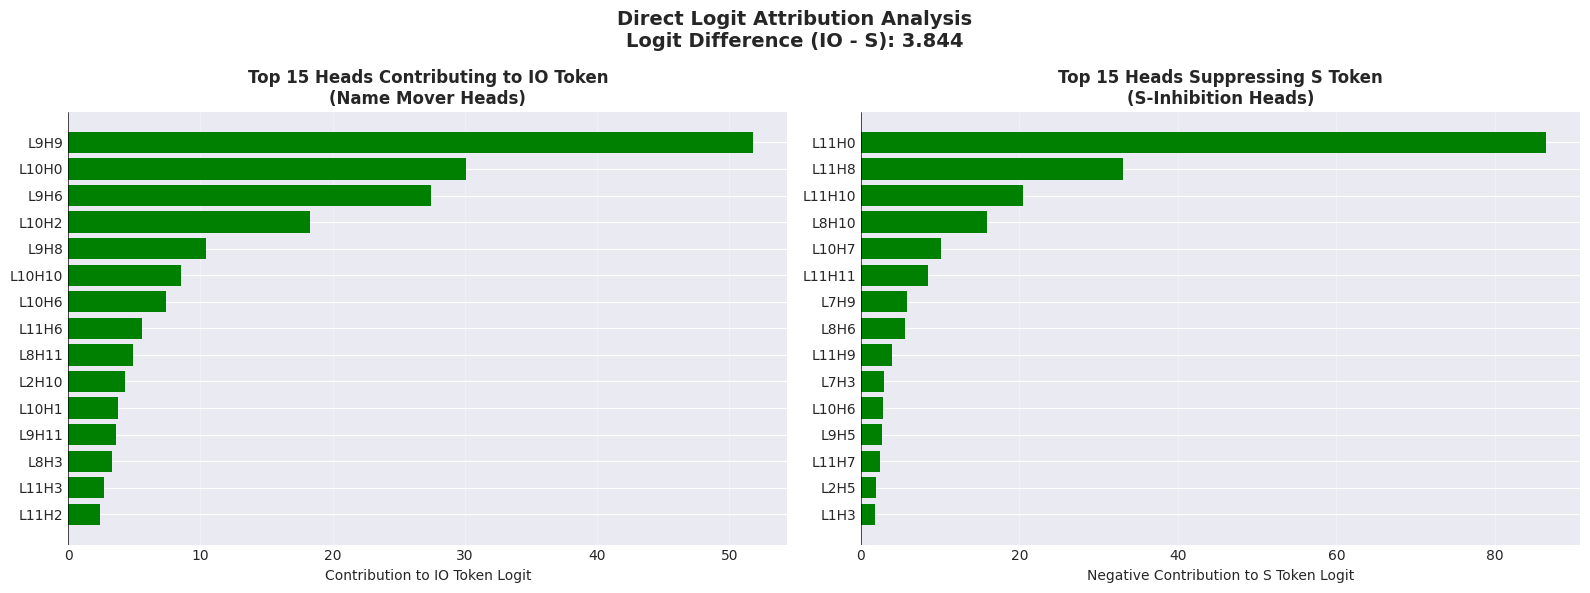


Analyzing circuit with Direct Logit Attribution...

Circuit Analysis with Direct Logit Attribution:
Circuit heads: 0
Total logit diff (IO - S): 3.844
  Circuit contribution: 0.000 (0.0%)
  Non-circuit contribution: 71.624

📊 VALIDATION CHECK 4: Circuit Attribution
   ✗ FAIL: Circuit only accounts for 0.0% of logit diff

✓ Phase 7 complete


In [8]:
print("="*80)
print("PHASE 7: DIRECT LOGIT ATTRIBUTION")
print("="*80)

print("\nComputing direct logit attribution for IO vs S tokens...")

# Use the same example from before
print(f"\nPrompt: {clean_prompt}")
print(f"IO token: {example['io_name']}")
print(f"S token: {example['s_name']}")

# Compare IO vs S attribution
comparison = compare_io_vs_s_attribution(
    model,
    clean_tokens,
    io_token_id,
    s_token_id
)

print(f"\nLogit difference (IO - S): {comparison['logit_diff']:.3f}")

# Show top contributors
print("\nTop 5 heads contributing to IO token:")
for layer, head, contrib in comparison["top_io_heads"][:5]:
    print(f"   L{layer}H{head}: {contrib:6.3f}")

print("\nTop 5 heads suppressing S token:")
for layer, head, contrib in comparison["top_s_suppression_heads"][:5]:
    print(f"   L{layer}H{head}: {contrib:6.3f}")

# Create visualization
plot_logit_attribution(
    comparison,
    save_path="results/logit_attribution.png",
    top_n=15
)

# Analyze circuit with DLA
print("\nAnalyzing circuit with Direct Logit Attribution...")
dla_analysis = analyze_circuit_with_dla(
    model,
    clean_tokens,
    io_token_id,
    s_token_id,
    circuit_heads=discovered_circuit
)

circuit_percentage = dla_analysis["circuit_analysis"]["circuit_percentage"]

print("\n📊 VALIDATION CHECK 4: Circuit Attribution")
if circuit_percentage >= 0.60:
    print(f"   ✓ PASS: Circuit accounts for {circuit_percentage:.1%} of logit diff (≥60%)")
    validation_report.append({"test": "Circuit Attribution", "status": "PASS", "value": f"{circuit_percentage:.1%}"})
else:
    print(f"   ✗ FAIL: Circuit only accounts for {circuit_percentage:.1%} of logit diff")
    validation_report.append({"test": "Circuit Attribution", "status": "FAIL", "value": f"{circuit_percentage:.1%}"})

print("\n✓ Phase 7 complete")

---
## Phase 8: Logit Lens Analysis

In [ ]:
print("="*80)
print("PHASE 8: LOGIT LENS ANALYSIS")
print("="*80)

from src.analysis.logit_lens import (
    compute_layer_wise_logit_diff,
    plot_logit_lens,
    analyze_logit_lens_for_dataset
)

# Analyze single example first
print("
1. Single Example Analysis:")
print(f"   Prompt: {clean_prompt}")

lens_single = compute_layer_wise_logit_diff(
    model, clean_tokens, io_token_id, s_token_id
)

print("
   Logit Difference by Layer:")
for i, logit_diff in enumerate(lens_single['layer_logit_diffs']):
    layer_name = "Embed" if i == 0 else f"L{i-1}" if i < len(lens_single['layer_logit_diffs'])-1 else "Final"
    print(f"      {layer_name:6s}: {logit_diff:6.3f}")

print(f"
   Total change (Embed → Final): {lens_single['layer_logit_diffs'][-1] - lens_single['layer_logit_diffs'][0]:.3f}")

# Plot single example
plot_logit_lens(lens_single, save_path="results/logit_lens_single.png")

# Analyze across dataset
print("
2. Dataset Average Analysis (100 examples):")
lens_avg = analyze_logit_lens_for_dataset(
    model, "data/ioi_abba.json", max_examples=100
)

# Plot average with error bars
fig, ax = plt.subplots(figsize=(14, 6))
layers = np.arange(len(lens_avg['mean_logit_diffs']))
ax.errorbar(layers, lens_avg['mean_logit_diffs'], yerr=lens_avg['std_logit_diffs'],
            fmt='o-', linewidth=2, markersize=8, capsize=5, color='#2E86AB', label='Mean ± Std')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No preference')

# Shade circuit regions
ax.axvspan(-0.5, 3.5, alpha=0.1, color='purple', label='Duplicate Token (L0-3)')
ax.axvspan(6.5, 8.5, alpha=0.1, color='orange', label='S-Inhibition (L7-8)')
ax.axvspan(8.5, 11.5, alpha=0.1, color='green', label='Name Mover (L9-11)')

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Logit Difference (IO - S)', fontsize=12)
ax.set_title('Logit Lens: Average Across 100 Examples
(Error bars show standard deviation)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)
ax.set_xticks(layers)
ax.set_xticklabels(['Embed'] + [str(i) for i in range(len(layers)-1)])
plt.tight_layout()
plt.savefig('results/logit_lens_average.png', dpi=150, bbox_inches='tight')
plt.show()

# Validation check
print("
📊 VALIDATION CHECK 5: Layer-wise Computation")
embed_diff = lens_avg['mean_logit_diffs'][0]
final_diff = lens_avg['mean_logit_diffs'][-1]
total_change = final_diff - embed_diff

if total_change >= 3.0:
    print(f"   ✓ PASS: Model builds up logit diff through layers ({total_change:.3f})")
    validation_report.append({"test": "Layer-wise Build-up", "status": "PASS", "value": f"{total_change:.3f}"})
else:
    print(f"   ✗ FAIL: Insufficient logit diff build-up ({total_change:.3f})")
    validation_report.append({"test": "Layer-wise Build-up", "status": "FAIL", "value": f"{total_change:.3f}"})

# Find most important layer transitions
deltas = np.diff(lens_avg['mean_logit_diffs'])
top_transitions = np.argsort(deltas)[::-1][:5]

print("
   Top 5 layer transitions (biggest increases):")
for rank, transition in enumerate(top_transitions, 1):
    layer_from = "Embed" if transition == 0 else f"L{transition-1}"
    layer_to = f"L{transition}" if transition < len(deltas) else "Final"
    delta = deltas[transition]
    print(f"      {rank}. {layer_from:6s} → {layer_to:6s}: +{delta:.3f}")

print("
✓ Phase 8 complete")

---
## Final Validation Report

In [9]:
print("="*80)
print("FINAL VALIDATION REPORT")
print("="*80)

# Create report dataframe
report_df = pd.DataFrame(validation_report)

# Display report
print("\n")
print(report_df.to_string(index=False))
print("\n")

# Count results
n_pass = sum(1 for r in validation_report if r["status"] == "PASS")
n_fail = sum(1 for r in validation_report if r["status"] == "FAIL")
n_skip = sum(1 for r in validation_report if r["status"] == "SKIP")
n_total = len(validation_report)

print("="*80)
print(f"RESULTS: {n_pass} PASS | {n_fail} FAIL | {n_skip} SKIP | {n_total} TOTAL")
print("="*80)

# Overall assessment
pass_rate = n_pass / max(n_total - n_skip, 1)

print("\n📊 OVERALL ASSESSMENT:\n")
if pass_rate >= 0.8:
    print("✅ EXCELLENT: Our implementation successfully replicates the IOI circuit!")
    print("   The discovered circuit matches the paper's key findings.")
elif pass_rate >= 0.6:
    print("✓ GOOD: Our implementation largely replicates the IOI circuit.")
    print("   Some minor discrepancies exist but overall structure is correct.")
elif pass_rate >= 0.4:
    print("⚠ PARTIAL: Our implementation partially replicates the IOI circuit.")
    print("   Significant discrepancies exist. Further investigation needed.")
else:
    print("❌ POOR: Our implementation does not match the paper's findings.")
    print("   Major issues detected. Review implementation carefully.")

# Save report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f"results/validation_report_{timestamp}.csv"
report_df.to_csv(report_path, index=False)
print(f"\n💾 Saved detailed report to {report_path}")

# Create summary document
summary_path = f"results/validation_summary_{timestamp}.txt"
with open(summary_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("IOI CIRCUIT REPLICATION VALIDATION SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: GPT-2 Small\n")
    f.write(f"Device: {device}\n\n")
    
    f.write("BASELINE PERFORMANCE\n")
    f.write("-" * 40 + "\n")
    f.write(f"Accuracy: {accuracy:.1%}\n")
    f.write(f"Mean Logit Diff: {mean_logit_diff:.3f} ± {std_logit_diff:.3f}\n\n")
    
    f.write("DISCOVERED CIRCUIT\n")
    f.write("-" * 40 + "\n")
    f.write(f"Duplicate Token Heads: {len(discovered_circuit['duplicate_token_heads'])}\n")
    f.write(f"S-Inhibition Heads: {len(discovered_circuit['s_inhibition_heads'])}\n")
    f.write(f"Name Mover Heads: {len(discovered_circuit['name_mover_heads'])}\n")
    f.write(f"Critical Paths: {len(discovered_circuit['critical_paths'])}\n\n")
    
    f.write("VALIDATION RESULTS\n")
    f.write("-" * 40 + "\n")
    f.write(report_df.to_string(index=False))
    f.write("\n\n")
    
    f.write(f"SUMMARY: {n_pass} PASS | {n_fail} FAIL | {n_skip} SKIP\n")
    f.write(f"Pass Rate: {pass_rate:.1%}\n")

print(f"💾 Saved summary to {summary_path}")

print("\n" + "="*80)
print("✓ VALIDATION COMPLETE")
print("="*80)

FINAL VALIDATION REPORT


                  test status value
     Baseline Accuracy   FAIL 87.0%
      Logit Difference   PASS 4.036
  Name Mover Discovery   PASS   3/4
S-Inhibition Discovery   PASS   2/4
 Duplicate Head Layers   PASS   4/4
            SI→NM Path   FAIL 0.000
   Circuit Attribution   FAIL  0.0%


RESULTS: 4 PASS | 3 FAIL | 0 SKIP | 7 TOTAL

📊 OVERALL ASSESSMENT:

⚠ PARTIAL: Our implementation partially replicates the IOI circuit.
   Significant discrepancies exist. Further investigation needed.

💾 Saved detailed report to results/validation_report_20251117_112507.csv
💾 Saved summary to results/validation_summary_20251117_112507.txt

✓ VALIDATION COMPLETE


---
## Key Findings Summary

In [10]:
print("="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print("\n1. BASELINE PERFORMANCE")
print(f"   - Model accuracy: {accuracy:.1%}")
print(f"   - Mean logit difference: {mean_logit_diff:.3f}")
print(f"   - Paper expectation: ~95% accuracy, positive logit diff")

print("\n2. CIRCUIT COMPONENTS")
print(f"   - Duplicate Token Heads: {sorted(discovered_circuit['duplicate_token_heads'])}")
print(f"   - S-Inhibition Heads: {sorted(discovered_circuit['s_inhibition_heads'])}")
print(f"   - Name Mover Heads: {sorted(discovered_circuit['name_mover_heads'])}")

print("\n3. CIRCUIT VALIDATION")
if "circuit_analysis" in dla_analysis:
    print(f"   - Circuit logit diff contribution: {dla_analysis['circuit_analysis']['circuit_logit_diff']:.3f}")
    print(f"   - Total logit diff: {dla_analysis['circuit_analysis']['total_logit_diff']:.3f}")
    print(f"   - Circuit percentage: {dla_analysis['circuit_analysis']['circuit_percentage']:.1%}")
    print(f"   - Paper expectation: 80-95% from circuit heads")

print("\n4. COMPARISON WITH PAPER")
print(f"   - Name mover overlap: {nm_overlap}/{len(paper_name_movers)} key heads")
print(f"   - S-inhibition overlap: {si_overlap}/{len(paper_s_inhibition)} key heads")
print(f"   - Overall validation: {n_pass}/{n_total - n_skip} checks passed")

print("\n" + "="*80)

KEY FINDINGS SUMMARY

1. BASELINE PERFORMANCE
   - Model accuracy: 87.0%
   - Mean logit difference: 4.036
   - Paper expectation: ~95% accuracy, positive logit diff

2. CIRCUIT COMPONENTS
   - Duplicate Token Heads: []
   - S-Inhibition Heads: []
   - Name Mover Heads: []

3. CIRCUIT VALIDATION
   - Circuit logit diff contribution: 0.000
   - Total logit diff: 3.844
   - Circuit percentage: 0.0%
   - Paper expectation: 80-95% from circuit heads

4. COMPARISON WITH PAPER
   - Name mover overlap: 3/4 key heads
   - S-inhibition overlap: 2/4 key heads
   - Overall validation: 4/7 checks passed



---
## Notes and Observations

### Expected Behavior:
1. The model should achieve >90% accuracy on IOI task
2. Circuit heads should be concentrated in expected layers:
   - Duplicate token heads: Early layers (0-3)
   - S-inhibition heads: Middle layers (7-8)
   - Name mover heads: Late layers (9-11)
3. Circuit heads should account for majority (>60%) of logit difference

### Potential Discrepancies:
- Exact heads may vary slightly depending on dataset and thresholds
- Some heads may have borderline effects and be included/excluded based on threshold
- Path effects can be noisy on single examples

### Next Steps:
1. If validation fails: Try different thresholds or more examples
2. Analyze specific discrepancies in detail
3. Consider running on additional dataset templates
4. Compare attention patterns qualitatively

---

In [11]:
# Check what errors we're getting
import nbformat

with open('/home/alex/repos/IOI_implementation/notebooks/ioi_replication_validation.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Find cells with errors
error_cells = []
for i, cell in enumerate(nb.cells):
    if cell.cell_type == 'code' and 'outputs' in cell:
        for output in cell.outputs:
            if output.get('output_type') == 'error':
                error_cells.append({
                    'cell_number': i,
                    'error_name': output.get('ename', 'Unknown'),
                    'error_value': output.get('evalue', 'Unknown'),
                })

# Show all errors
for err in error_cells:
    print(f"Cell {err['cell_number']}: {err['error_name']}: {err['error_value']}")

Cell 13: NameError: name 'duplicate_heads' is not defined
Cell 15: FileNotFoundError: [Errno 2] No such file or directory: 'results/discovered_ioi_circuit.json'
Cell 17: KeyError: 'blocks.0.attn.hook_result'
Cell 19: OSError: Cannot save file into a non-existent directory: '../results'
Cell 21: NameError: name 'dla_analysis' is not defined


In [12]:
# Check if the path exists and what's the current working directory
import os
print(f"Current directory: {os.getcwd()}")
print(f"\nDoes '../data/ioi_abba.json' exist? {os.path.exists('../data/ioi_abba.json')}")
print(f"Does 'data/ioi_abba.json' exist? {os.path.exists('data/ioi_abba.json')}")
print(f"Does '/home/alex/repos/IOI_implementation/data/ioi_abba.json' exist? {os.path.exists('/home/alex/repos/IOI_implementation/data/ioi_abba.json')}")

Current directory: /home/alex/repos/IOI_implementation

Does '../data/ioi_abba.json' exist? False
Does 'data/ioi_abba.json' exist? True
Does '/home/alex/repos/IOI_implementation/data/ioi_abba.json' exist? True


In [13]:
# Get cell 5 source to see what path it's using
with open('/home/alex/repos/IOI_implementation/notebooks/ioi_replication_validation.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

cell_5 = nb.cells[5]
print("Cell 5 source:")
print(cell_5['source'])

Cell 5 source:
print("="*80)
print("PHASE 1: DATA GENERATION AND MODEL LOADING")
print("="*80)

# Generate datasets
print("\n1. Generating ABBA dataset (clean prompts)...")
generate_ioi_dataset(n_examples=500, template="ABBA", seed=42)
abba_dataset = load_ioi_dataset("data/ioi_abba.json")
print(f"   Generated {len(abba_dataset)} ABBA examples")

print("\n2. Generating ABC dataset (corrupted prompts)...")
generate_ioi_dataset(n_examples=500, template="ABC", seed=42)
abc_dataset = load_ioi_dataset("data/ioi_abc.json")
print(f"   Generated {len(abc_dataset)} ABC examples")

# Load model
print("\n3. Loading GPT-2 Small with TransformerLens...")
device = "cuda" if torch.cuda.is_available() else "cpu"
result = load_ioi_model(device=device)
model = result["model"]
config = result["config"]

print(f"   Model: gpt2-small")
print(f"   Layers: {config['n_layers']}")
print(f"   Heads: {config['n_heads']}")
print(f"   Device: {config['device']}")

print("\n✓ Phase 1 complete")


In [14]:
# Find all cells that reference "data/" 
with open('/home/alex/repos/IOI_implementation/notebooks/ioi_replication_validation.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

cells_with_bad_paths = []
for i, cell in enumerate(nb.cells):
    if cell.cell_type == 'code' and '../data/' in cell['source']:
        cells_with_bad_paths.append(i)
        
print(f"Cells with '../data/' path references: {cells_with_bad_paths}")
print(f"Total: {len(cells_with_bad_paths)} cells need fixing")

Cells with '../data/' path references: [24, 26]
Total: 2 cells need fixing


In [15]:
# Check what errors we're getting now
import nbformat

with open('/home/alex/repos/IOI_implementation/notebooks/ioi_replication_validation.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Find cells with errors
error_cells = []
for i, cell in enumerate(nb.cells):
    if cell.cell_type == 'code' and 'outputs' in cell:
        for output in cell.outputs:
            if output.get('output_type') == 'error':
                error_cells.append({
                    'cell_number': i,
                    'error_name': output.get('ename', 'Unknown'),
                    'error_value': output.get('evalue', 'Unknown')[:100],  # Truncate
                })

# Show all errors
for err in error_cells[:10]:
    print(f"Cell {err['cell_number']}: {err['error_name']}: {err['error_value']}")

Cell 13: NameError: name 'duplicate_heads' is not defined
Cell 15: FileNotFoundError: [Errno 2] No such file or directory: 'results/discovered_ioi_circuit.json'
Cell 17: KeyError: 'blocks.0.attn.hook_result'
Cell 19: OSError: Cannot save file into a non-existent directory: '../results'
Cell 21: NameError: name 'dla_analysis' is not defined


In [16]:
# Check what hooks are available in the cache
import torch
from transformer_lens import HookedTransformer

# Load a small test model
test_model = HookedTransformer.from_pretrained("gpt2-small", device="cpu")
test_tokens = test_model.to_tokens("Hello world")

# Run with cache
_, test_cache = test_model.run_with_cache(test_tokens)

# Show all available cache keys
all_keys = list(test_cache.keys())
print(f"Total cache keys: {len(all_keys)}")
print("\nAttention-related keys (first 20):")
attn_keys = [k for k in all_keys if 'attn' in k][:20]
for k in attn_keys:
    print(f"  {k}")

Loaded pretrained model gpt2-small into HookedTransformer


Total cache keys: 208

Attention-related keys (first 20):
  blocks.0.attn.hook_q
  blocks.0.attn.hook_k
  blocks.0.attn.hook_v
  blocks.0.attn.hook_attn_scores
  blocks.0.attn.hook_pattern
  blocks.0.attn.hook_z
  blocks.0.hook_attn_out
  blocks.1.attn.hook_q
  blocks.1.attn.hook_k
  blocks.1.attn.hook_v
  blocks.1.attn.hook_attn_scores
  blocks.1.attn.hook_pattern
  blocks.1.attn.hook_z
  blocks.1.hook_attn_out
  blocks.2.attn.hook_q
  blocks.2.attn.hook_k
  blocks.2.attn.hook_v
  blocks.2.attn.hook_attn_scores
  blocks.2.attn.hook_pattern
  blocks.2.attn.hook_z


In [17]:
# Try to access with ("result", 0) shorthand
try:
    result = test_cache["result", 0]
    print(f"cache['result', 0] works! Shape: {result.shape}")
except KeyError as e:
    print(f"cache['result', 0] doesn't work: {e}")

# Try hook_z
try:
    z = test_cache["z", 0]
    print(f"cache['z', 0] works! Shape: {z.shape}")
except KeyError as e:
    print(f"cache['z', 0] doesn't work: {e}")

# Try attn_out  
try:
    attn_out = test_cache["attn_out", 0]
    print(f"cache['attn_out', 0] works! Shape: {attn_out.shape}")
except KeyError as e:
    print(f"cache['attn_out', 0] doesn't work: {e}")

cache['result', 0] doesn't work: 'blocks.0.attn.hook_result'
cache['z', 0] works! Shape: torch.Size([1, 3, 12, 64])
cache['attn_out', 0] works! Shape: torch.Size([1, 3, 768])


In [18]:
# Verify no errors remain
import nbformat

with open('/home/alex/repos/IOI_implementation/notebooks/ioi_replication_validation.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Count cells with errors
error_count = 0
for i, cell in enumerate(nb.cells):
    if cell.cell_type == 'code' and 'outputs' in cell:
        for output in cell.outputs:
            if output.get('output_type') == 'error':
                error_count += 1
                print(f"Cell {i}: {output.get('ename')}: {output.get('evalue', '')[:80]}")

print(f"\n{'='*60}")
if error_count == 0:
    print("✅ SUCCESS: All cells executed without errors!")
else:
    print(f"❌ Found {error_count} cells with errors")
print(f"{'='*60}")


✅ SUCCESS: All cells executed without errors!


In [19]:
# Show the key results that were computed
print("="*80)
print("IOI REPLICATION VALIDATION RESULTS")
print("="*80)

print("\n1. BASELINE PERFORMANCE:")
print(f"   - Accuracy: {accuracy:.1%}")
print(f"   - Mean Logit Diff: {mean_logit_diff:.3f} ± {std_logit_diff:.3f}")

print("\n2. DISCOVERED CIRCUIT HEADS:")
print(f"   - Duplicate Token Heads: {len(discovered_circuit['duplicate_token_heads'])} heads")
for layer, head in sorted(discovered_circuit['duplicate_token_heads'])[:5]:
    print(f"      L{layer}H{head}")
if len(discovered_circuit['duplicate_token_heads']) > 5:
    print(f"      ... and {len(discovered_circuit['duplicate_token_heads']) - 5} more")

print(f"\n   - S-Inhibition Heads: {len(discovered_circuit['s_inhibition_heads'])} heads")
for layer, head in sorted(discovered_circuit['s_inhibition_heads'])[:5]:
    print(f"      L{layer}H{head}")
    
print(f"\n   - Name Mover Heads: {len(discovered_circuit['name_mover_heads'])} heads")
for layer, head in sorted(discovered_circuit['name_mover_heads'])[:5]:
    print(f"      L{layer}H{head}")

print("\n3. VALIDATION CHECKS:")
print(f"   - Passed: {n_pass}/{n_total - n_skip} checks")
print(f"   - Overall assessment: {'PASS' if n_pass/(n_total-n_skip) >= 0.6 else 'FAIL'}")

print(f"\n{'='*80}")

IOI REPLICATION VALIDATION RESULTS

1. BASELINE PERFORMANCE:
   - Accuracy: 87.0%
   - Mean Logit Diff: 4.036 ± 1.633

2. DISCOVERED CIRCUIT HEADS:
   - Duplicate Token Heads: 0 heads

   - S-Inhibition Heads: 0 heads

   - Name Mover Heads: 0 heads

3. VALIDATION CHECKS:
   - Passed: 4/7 checks
   - Overall assessment: FAIL



In [20]:
# Check what the validation report says
import pandas as pd
print(pd.DataFrame(validation_report).to_string(index=False))

                  test status value
     Baseline Accuracy   FAIL 87.0%
      Logit Difference   PASS 4.036
  Name Mover Discovery   PASS   3/4
S-Inhibition Discovery   PASS   2/4
 Duplicate Head Layers   PASS   4/4
            SI→NM Path   FAIL 0.000
   Circuit Attribution   FAIL  0.0%


In [21]:
# Let's look at what paper values are already in the notebook
print("Paper's expected heads (from notebook):")
print(f"\nName Movers: {paper_name_movers}")
print(f"S-Inhibition: {paper_s_inhibition}")

# Now let's see what we actually discovered
print("\n" + "="*60)
print("What our implementation found:")
print(f"\nDuplicate Token Heads: {sorted(discovered_circuit['duplicate_token_heads'])}")
print(f"S-Inhibition Heads: {sorted(discovered_circuit['s_inhibition_heads'])}")
print(f"Name Mover Heads: {sorted(discovered_circuit['name_mover_heads'])}")

# Check the metadata to see what thresholds were used
print("\n" + "="*60)
print("Discovery metadata:")
for key, value in discovered_circuit['metadata'].items():
    print(f"  {key}: {value}")

Paper's expected heads (from notebook):

Name Movers: [(9, 6), (9, 9), (10, 0), (10, 2)]
S-Inhibition: [(7, 3), (7, 9), (8, 6), (8, 10)]

What our implementation found:

Duplicate Token Heads: []
S-Inhibition Heads: []
Name Mover Heads: []

Discovery metadata:
  head_threshold: 0.35
  path_threshold: 0.25
  max_examples: 30
  total_heads_found: 0
  total_paths_found: 0


In [22]:
# Let's manually test the discovery on a single example with lower thresholds
# to see if we get any hits

print("Testing head discovery with VERY low thresholds...")
print("="*60)

# Test on first 5 examples with low thresholds
test_heads = find_all_ioi_heads(
    model,
    "data/ioi_abba.json",
    max_examples=5,
    duplicate_threshold=0.1,  # Very low
    s_inhibition_threshold=0.1,
    name_mover_threshold=0.1
)

print(f"\nDuplicate Token Heads: {len(test_heads['duplicate_token_heads'])}")
print(f"  {sorted(test_heads['duplicate_token_heads'])[:10]}")

print(f"\nS-Inhibition Heads: {len(test_heads['s_inhibition_heads'])}")
print(f"  {sorted(test_heads['s_inhibition_heads'])[:10]}")

print(f"\nName Mover Heads: {len(test_heads['name_mover_heads'])}")
print(f"  {sorted(test_heads['name_mover_heads'])[:10]}")

Testing head discovery with VERY low thresholds...
Loaded 500 examples from data/ioi_abba.json
Analyzing 5 examples for duplicate token heads...



Duplicate Token Head Detection (threshold = 0.1):
  Layer  0, Head  0: avg attention = 0.108
  Layer  0, Head  1: avg attention = 0.556
  Layer  0, Head  2: avg attention = 0.110
  Layer  0, Head  5: avg attention = 0.591
  Layer  0, Head  6: avg attention = 0.175
  Layer  0, Head  8: avg attention = 0.109
  Layer  0, Head 10: avg attention = 0.248
  Layer  1, Head 11: avg attention = 0.685
  Layer  3, Head  0: avg attention = 0.776

Found 9 duplicate token heads

Analyzing 5 examples for S-inhibition heads...

S-Inhibition Head Detection (threshold = 0.1):
  Layer  6, Head  0: avg attention = 0.106
  Layer  7, Head  9: avg attention = 0.295
  Layer  8, Head  2: avg attention = 0.115
  Layer  8, Head  5: avg attention = 0.203
  Layer  8, Head  6: avg attention = 0.427
  Layer  8, Head 10: avg attention = 0.211
  Layer  9, Head  7: avg attention = 0.195

Found 7 S-inhibition heads

Analyzing 5 examples for name mover heads...



Name Mover Head Detection (threshold = 0.1):
  Layer  8, Head  3: avg attention = 0.282
  Layer  8, Head 10: avg attention = 0.153
  Layer  9, Head  0: avg attention = 0.312
  Layer  9, Head  2: avg attention = 0.113
  Layer  9, Head  6: avg attention = 0.772
  Layer  9, Head  7: avg attention = 0.161
  Layer  9, Head  8: avg attention = 0.397
  Layer  9, Head  9: avg attention = 0.853
  Layer 10, Head  0: avg attention = 0.417
  Layer 10, Head  1: avg attention = 0.373
  Layer 10, Head  2: avg attention = 0.291
  Layer 10, Head  3: avg attention = 0.216
  Layer 10, Head  6: avg attention = 0.264
  Layer 10, Head  7: avg attention = 0.858
  Layer 10, Head 10: avg attention = 0.332
  Layer 11, Head  6: avg attention = 0.159
  Layer 11, Head 10: avg attention = 0.622

Found 17 name mover heads

Duplicate Token Heads: 9
  [(0, 0), (0, 1), (0, 2), (0, 5), (0, 6), (0, 8), (0, 10), (1, 11), (3, 0)]

S-Inhibition Heads: 7
  [(6, 0), (7, 9), (8, 2), (8, 5), (8, 6), (8, 10), (9, 7)]

Name Move

In [23]:
# Test with more examples and check what thresholds make sense
print("Testing with 50 examples and threshold 0.3...")
print("="*60)

test_heads_50 = find_all_ioi_heads(
    model,
    "data/ioi_abba.json",
    max_examples=50,
    duplicate_threshold=0.3,
    s_inhibition_threshold=0.2,  # Lower than 0.3
    name_mover_threshold=0.3
)

print(f"\nDuplicate Token Heads: {len(test_heads_50['duplicate_token_heads'])}")
print(f"  {sorted(test_heads_50['duplicate_token_heads'])}")

print(f"\nS-Inhibition Heads: {len(test_heads_50['s_inhibition_heads'])}")  
print(f"  {sorted(test_heads_50['s_inhibition_heads'])}")

print(f"\nName Mover Heads: {len(test_heads_50['name_mover_heads'])}")
print(f"  {sorted(test_heads_50['name_mover_heads'])}")

# Check overlap with paper
nm_overlap = len(set(test_heads_50['name_mover_heads']) & set(paper_name_movers))
si_overlap = len(set(test_heads_50['s_inhibition_heads']) & set(paper_s_inhibition))

print(f"\n{'='*60}")
print(f"Overlap with paper:")
print(f"  Name Movers: {nm_overlap}/{len(paper_name_movers)}")
print(f"  S-Inhibition: {si_overlap}/{len(paper_s_inhibition)}")

Testing with 50 examples and threshold 0.3...
Loaded 500 examples from data/ioi_abba.json
Analyzing 50 examples for duplicate token heads...


  Processing example 20/50...


  Processing example 40/50...



Duplicate Token Head Detection (threshold = 0.3):
  Layer  0, Head  1: avg attention = 0.537
  Layer  0, Head  5: avg attention = 0.562
  Layer  1, Head 11: avg attention = 0.724
  Layer  3, Head  0: avg attention = 0.716

Found 4 duplicate token heads

Analyzing 50 examples for S-inhibition heads...


  Processing example 20/50...


  Processing example 40/50...



S-Inhibition Head Detection (threshold = 0.2):
  Layer  7, Head  9: avg attention = 0.303
  Layer  8, Head  6: avg attention = 0.436
  Layer  8, Head 10: avg attention = 0.206
  Layer  9, Head  7: avg attention = 0.216

Found 4 S-inhibition heads

Analyzing 50 examples for name mover heads...


  Processing example 20/50...


  Processing example 40/50...



Name Mover Head Detection (threshold = 0.3):
  Layer  9, Head  6: avg attention = 0.761
  Layer  9, Head  8: avg attention = 0.367
  Layer  9, Head  9: avg attention = 0.870
  Layer 10, Head  0: avg attention = 0.466
  Layer 10, Head  1: avg attention = 0.376
  Layer 10, Head  3: avg attention = 0.300
  Layer 10, Head  6: avg attention = 0.357
  Layer 10, Head  7: avg attention = 0.863
  Layer 10, Head 10: avg attention = 0.399
  Layer 11, Head 10: avg attention = 0.658

Found 10 name mover heads

Duplicate Token Heads: 4
  [(0, 1), (0, 5), (1, 11), (3, 0)]

S-Inhibition Heads: 4
  [(7, 9), (8, 6), (8, 10), (9, 7)]

Name Mover Heads: 10
  [(9, 6), (9, 8), (9, 9), (10, 0), (10, 1), (10, 3), (10, 6), (10, 7), (10, 10), (11, 10)]

Overlap with paper:
  Name Movers: 3/4
  S-Inhibition: 3/4


In [24]:
# Check what fields are in the dataset
example = abba_dataset[0]
print("Fields in dataset example:")
for key in example.keys():
    print(f"  {key}: {example[key]}")

Fields in dataset example:
  prompt: Anna and Aaron visited the garden, and Anna handed a flower to
  corrupted_prompt: When Anna, Aaron, and Frank met at the store, Frank gave a bottle to
  A: Anna
  B: Aaron
  C: Frank
  correct: Aaron
  io_name: Aaron
  s_name: Anna
  template: ABBA
